# Custom Model with PyTorch

Aqua-blue provides functionality to create custom systems using other libraries such as `torch`. In this example, we will create an aqua-blue model with `torch`, and use a MLP (Multilayer Perceptron) for the readout layer. 

## Example problem

We will be predicting the system

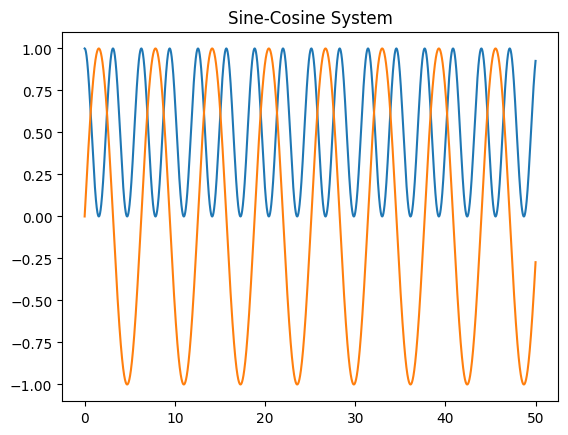

In [1]:
import torch
import matplotlib.pyplot as plt

t = torch.arange(5_000, dtype=torch.float64) / 100
y = torch.vstack((torch.cos(t) ** 2, torch.sin(t))).T

t1 = torch.arange(50, 60, 0.01, dtype=torch.float64)
y1 = torch.vstack((torch.cos(t1) ** 2, torch.sin(t1))).T

plt.plot(t, y)
plt.title('Sine-Cosine System')
plt.show()

## Aqua-blue Torch Model
The underlying mechanics do not change much (except for the readout), so all we need to do is perform the necessary casts to `torch.Tensor`.

### Reservoir

In [2]:
from dataclasses import dataclass
import aqua_blue

@dataclass
class DynamicalReservoirWithTorch(aqua_blue.reservoirs.DynamicalReservoir):
    
    def __post_init__(self):
        
        super().__post_init__()
        
        self.w_in = torch.tensor(self.w_in)
        self.w_res = torch.tensor(self.w_res)
        self.res_state = torch.tensor(self.res_state)
    
    def update_reservoir(self, input_state: torch.Tensor) -> torch.Tensor:
        
        self.res_state = (1.0 - self.leaking_rate) * self.res_state + self.leaking_rate * self.activation_function(
            self.w_in @ input_state + self.w_res @ self.res_state
        )
        return self.res_state

### TimeSeries

In [3]:
@dataclass
class TimeSeriesWithTorch(aqua_blue.time_series.TimeSeries):
    
    def __post_init__(self):
        super().__post_init__()
        self.dependent_variable = torch.tensor(self.dependent_variable)
        self.times = torch.tensor(self.times.astype(float))

### Model

In [4]:
@dataclass
class ModelWithTorch(aqua_blue.models.Model):
    
    def train(
        self,
        input_time_series: TimeSeriesWithTorch,
        warmup: int = 0
    ):
        
        time_series_array = input_time_series.dependent_variable
        reservoir_states = torch.zeros((time_series_array.shape[0]-1, self.reservoir.reservoir_dimensionality))

        for i in range(reservoir_states.shape[0]):
            reservoir_states[i] = self.reservoir.update_reservoir(time_series_array[i])

        dependent_variables = time_series_array[1:]
        if warmup > 0:
            reservoir_states = reservoir_states[warmup:]
            dependent_variables = dependent_variables[warmup:]
        
        self.readout.train(reservoir_states, dependent_variables)
        self.timestep = input_time_series.timestep
        self.final_time = input_time_series.times[-1]
        self.tz = input_time_series.times.tz
        self.times_dtype = input_time_series.times.dtype
        self.initial_guess = time_series_array[-1, :]

    def predict(self, horizon: int) -> TimeSeriesWithTorch:
        
        predictions = torch.zeros((horizon, self.reservoir.input_dimensionality), dtype=float)
        
        for i in range(horizon):
            if i == 0:
                predictions[i, :] = self.readout.reservoir_to_output(
                    self.reservoir.res_state
                )
                continue
            predictions[i, :] = self.readout.reservoir_to_output(
                self.reservoir.update_reservoir(predictions[i - 1, :])
            )
        
        if isinstance(self.final_time, float):
            assert isinstance(self.timestep, float)

        times_ = torch.arange(
            self.final_time + self.timestep,
            self.final_time + (horizon + 1) * self.timestep,
            self.timestep,
            dtype=float
        )

        return TimeSeriesWithTorch(
            dependent_variable=predictions,
            times=times_
        )

### MLP Readout

In [5]:
from sklearn.neural_network import MLPRegressor
import numpy as np 

@dataclass
class MLPReadoutWithTorch(aqua_blue.readouts.LinearReadout):
    
    def train(self, reservoir_states: torch.Tensor, dependent_variables: torch.Tensor):
        
        reservoir_states = torch.Tensor(reservoir_states)
        dependent_variables = torch.Tensor(dependent_variables)
        
        self.mlp = MLPRegressor(hidden_layer_sizes=(64, 32),
                   activation='relu',
                   solver='adam',
                   max_iter=500,
                   random_state=0)

        self.mlp.fit(reservoir_states, dependent_variables)
    
    def reservoir_to_output(self, reservoir_state):
        reservoir_state = np.reshape(reservoir_state, (1, -1))
        return torch.Tensor(self.mlp.predict(reservoir_state))

## Hyperparameter Optimization

Let's use `aqua-blue-hyperopt` to find the optimal hyperparameters for this task. 

In [7]:
import aqua_blue_hyperopt
import hyperopt
from aqua_blue_hyperopt.hyper import ModelParams, HyperParams, Output
from aqua_blue.utilities import Normalizer

from typing import Callable, Optional 
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

@dataclass
class ModelParamsWithTorch(ModelParams):
    time_series: TimeSeriesWithTorch
    readout: MLPReadoutWithTorch
    actual_future: torch.Tensor
    w_in: Optional[torch.Tensor] = None 
    w_res: Optional[torch.Tensor] = None

class HyperParamsWithTorch(HyperParams): 
    spectral_radius: hyperopt.pyll.base.Apply
    leaking_rate: hyperopt.pyll.base.Apply
    sparsity: hyperopt.pyll.base.Apply

space: HyperParamsWithTorch = {
    'spectral_radius': hyperopt.hp.uniform('spectral_radius', 0.1, 1.5),
    'leaking_rate': hyperopt.hp.uniform('leaking_rate', 0.0, 1.0),
    'sparsity': hyperopt.hp.uniform('sparsity', 0.0, 1.0),
}

def loss(mp: ModelParamsWithTorch) -> Callable[[HyperParamsWithTorch], Output]:
    def inner(p : HyperParamsWithTorch) -> Output: 
        spectral_radius, leaking_rate, sparsity = p['spectral_radius'], p['leaking_rate'], p['sparsity']
        
        normalizer = Normalizer()
        model = ModelWithTorch( 
            reservoir=DynamicalReservoirWithTorch(
                reservoir_dimensionality = mp.reservoir_dimensionality, 
                input_dimensionality = mp.input_dimensionality,
                w_res = mp.w_res, 
                w_in = mp.w_in,
                spectral_radius = spectral_radius,
                leaking_rate = leaking_rate, 
                sparsity = sparsity
            ),
            readout = mp.readout()
        )

        normalized_time_series = normalizer.normalize(mp.time_series)
        
        try: 
            model.train(normalized_time_series)
        except torch.linalg.LinAlgError:
            
            warnings.warn('SVD Error in Training', RuntimeWarning)
            return { 
                'loss': 1000, 
                'status': hyperopt.STATUS_FAIL
            }
        
        try: 
            prediction = model.predict(horizon = mp.horizon)
        except torch.linalg.LinAlgError:
            warnings.warn('SVD Error in Training', RuntimeWarning)
            return { 
                'loss': 1000, 
                'status': hyperopt.STATUS_FAIL
            }
        
        prediction = normalizer.denormalize(prediction)
        
        if prediction.dependent_variable.shape != mp.actual_future.shape:
            raise ValueError('Dimension mismatch between actual future and prediction')
        
        loss = torch.sqrt(torch.mean((mp.actual_future - prediction.dependent_variable) ** 2))

        out : Output = { 
            'loss': loss, 
            'status': hyperopt.STATUS_OK
        }
        
        return out 
    
    return inner

In [8]:
if torch.cuda.is_available():
    torch.set_default_device("cuda")
else:
    torch.set_default_device("cpu")

time_series = TimeSeriesWithTorch(dependent_variable=y, times=t)

mp = ModelParamsWithTorch(
    time_series=time_series,
    input_dimensionality=2, 
    reservoir_dimensionality=100,
    horizon=1_000,
    actual_future=y1, 
    readout=MLPReadoutWithTorch
)

fmin = loss(mp)

optimizer = aqua_blue_hyperopt.hyper.Optimizer(
    max_evals=1_000, 
    fn=fmin,
    space=space, 
    algo=aqua_blue_hyperopt.hyper.Algo.TREE_PARZEN_ESTIMATOR
)

best_params = optimizer.optimize()

100%|██████████| 1000/1000 [39:52<00:00,  2.39s/trial, best loss: 0.004976426317267799]


## Predictions

Let's use our new model to make predictions!

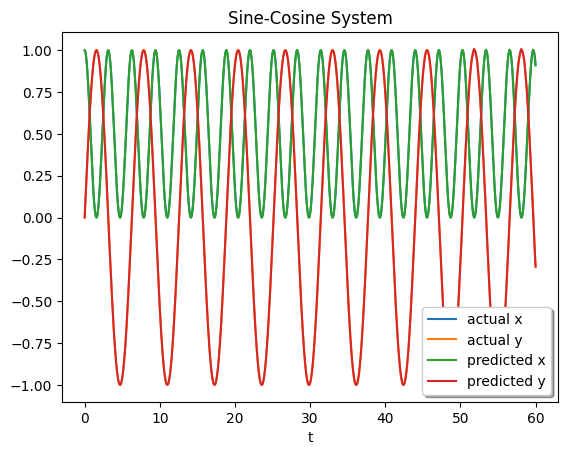

In [9]:
normalizer = aqua_blue.utilities.Normalizer()
time_series = normalizer.normalize(time_series)

model = ModelWithTorch(
    reservoir=DynamicalReservoirWithTorch(
        reservoir_dimensionality=100,
        input_dimensionality=2,
        activation_function=torch.tanh,
        spectral_radius=best_params['spectral_radius'],
        sparsity=best_params['sparsity'],
        leaking_rate=best_params['leaking_rate']
    ),
    readout=MLPReadoutWithTorch()
)
model.train(time_series)

prediction = model.predict(horizon=1_000)
prediction = normalizer.denormalize(prediction)

plt.plot(torch.concatenate((t,t1)), torch.vstack((y, y1)))
plt.xlabel('t')
plt.plot(torch.concatenate((t, t1)), torch.vstack((y, torch.Tensor(prediction.dependent_variable))))
plt.legend(['actual x', 'actual y', 'predicted x', 'predicted y'], shadow=True)
plt.title('Sine-Cosine System')
plt.show()